In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/5550/live/526975.png
#/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/5550/live/500232.png

In [3]:
# celeba dataset
celeba_data_dir = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/'
path_train_json = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/metas/intra_test/test_label.json'
path_test_json = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/metas/intra_test/test_label.json'
path_local = '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/'

In [4]:
# Standard library
import os

# Pytorch library
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v2
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader


# Library for data prep
import cv2
from matplotlib import pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
from tqdm import tqdm

In [5]:
# Check whether it has cuda accelerator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
class LivenessAntiSpoof(nn.Module):
    def __init__(self):
        super(LivenessAntiSpoof, self).__init__()
        # Load pretrained MobileNetV2
        self.pretrained_net = mobilenet_v2(pretrained=True)
        self.features = self.pretrained_net.features
        
        # Adding the extra layers
        self.conv2d = nn.Conv2d(1280, 32, kernel_size=(3, 3), padding=1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.features(x)
        x = self.conv2d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
# Instantiate the model and print the summary
model = LivenessAntiSpoof()
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 78.7MB/s]


LivenessAntiSpoof(
  (pretrained_net): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, k

In [7]:
df_train = pd.read_json(path_train_json, orient="index")
df_train.head()

0   1   2   3   4   5   6   7   8   9   ...  \
Data/test/6964/spoof/494405.png   0   0   0   0   0   0   0   0   0   0  ...   
Data/test/9596/spoof/494406.png   0   0   0   0   0   0   0   0   0   0  ...   
Data/test/9014/spoof/494407.png   0   0   0   0   0   0   0   0   0   0  ...   
Data/test/7607/spoof/494408.png   0   0   0   0   0   0   0   0   0   0  ...   
Data/test/5624/spoof/494409.png   0   0   0   0   0   0   0   0   0   0  ...   

                                 34  35  36  37  38  39  40  41  42  43  
Data/test/6964/spoof/494405.png   0   0   0   0   0   0   4   2   2   1  
Data/test/9596/spoof/494406.png   0   0   0   0   0   0   9   2   2   1  
Data/test/9014/spoof/494407.png   0   0   0   0   0   0   8   1   2   1  
Data/test/7607/spoof/494408.png   0   0   0   0   0   0   6   1   1   1  
Data/test/5624/spoof/494409.png   0   0   0   0   0   0   2   1   1   1  

[5 rows x 44 columns]

In [8]:
df_test = pd.read_json(path_test_json, orient="index")
df_test.head()

0   1   2   3   4   5   6   7   8   9   ...  \
Data/test/6964/spoof/494405.png   0   0   0   0   0   0   0   0   0   0  ...   
Data/test/9596/spoof/494406.png   0   0   0   0   0   0   0   0   0   0  ...   
Data/test/9014/spoof/494407.png   0   0   0   0   0   0   0   0   0   0  ...   
Data/test/7607/spoof/494408.png   0   0   0   0   0   0   0   0   0   0  ...   
Data/test/5624/spoof/494409.png   0   0   0   0   0   0   0   0   0   0  ...   

                                 34  35  36  37  38  39  40  41  42  43  
Data/test/6964/spoof/494405.png   0   0   0   0   0   0   4   2   2   1  
Data/test/9596/spoof/494406.png   0   0   0   0   0   0   9   2   2   1  
Data/test/9014/spoof/494407.png   0   0   0   0   0   0   8   1   2   1  
Data/test/7607/spoof/494408.png   0   0   0   0   0   0   6   1   1   1  
Data/test/5624/spoof/494409.png   0   0   0   0   0   0   2   1   1   1  

[5 rows x 44 columns]

In [9]:
df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_train.head()

index  0  1  2  3  4  5  6  7  8  ...  34  35  \
0  Data/test/6964/spoof/494405.png  0  0  0  0  0  0  0  0  0  ...   0   0   
1  Data/test/9596/spoof/494406.png  0  0  0  0  0  0  0  0  0  ...   0   0   
2  Data/test/9014/spoof/494407.png  0  0  0  0  0  0  0  0  0  ...   0   0   
3  Data/test/7607/spoof/494408.png  0  0  0  0  0  0  0  0  0  ...   0   0   
4  Data/test/5624/spoof/494409.png  0  0  0  0  0  0  0  0  0  ...   0   0   

   36  37  38  39  40  41  42  43  
0   0   0   0   0   4   2   2   1  
1   0   0   0   0   9   2   2   1  
2   0   0   0   0   8   1   2   1  
3   0   0   0   0   6   1   1   1  
4   0   0   0   0   2   1   1   1  

[5 rows x 45 columns]

In [10]:
df_train.rename({"index": "file_path"}, axis=1, inplace=True)
df_test.rename({"index": "file_path"}, axis=1, inplace=True)

In [11]:
df_train["file_path"] = df_train["file_path"].apply(lambda s: path_local + s)
df_test["file_path"] = df_test["file_path"].apply(lambda s: path_local + s)

In [12]:
# Spoof Type: Photo and Phone, [1, 9]
spoof_types = [0, 1, 9]
# Illumination Condition: All
# Environment: Indoor [1]
env_types = [0, 1]

In [13]:
df_train_sample = df_train[(df_train[40].isin(spoof_types)) & (df_train[42].isin(env_types))].reset_index(drop=True)
df_train_sample.shape

(26261, 45)

In [14]:
df_train_sample[40].value_counts()

40
0    19923
1     3177
9     3161
Name: count, dtype: int64

In [15]:
size = int(df_train_sample[40].value_counts()[1:].sum())

# train df
df_train_sample_zero = df_train_sample[df_train_sample[40] == 0][:size-100]
df_train_sample_nonzero = df_train_sample[df_train_sample[40] != 0][:size-100]
df_train_sample_balanced = pd.concat([df_train_sample_zero, df_train_sample_nonzero], ignore_index=True)

# val df
df_val_sample_zero = df_train_sample[df_train_sample[40] == 0][size-100:]
df_val_sample_nonzero = df_train_sample[df_train_sample[40] != 0][size-100:]
df_val_sample_balanced = pd.concat([df_val_sample_zero, df_val_sample_nonzero], ignore_index=True)

In [16]:
df_train_sample_balanced.shape

(12476, 45)

In [17]:
df_val_sample_balanced.shape

(13785, 45)

In [18]:
df_train_sample_balanced = df_train_sample_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_train_sample_balanced[43].value_counts()

43
1    6238
0    6238
Name: count, dtype: int64

In [19]:
df_val_sample_balanced = df_val_sample_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_val_sample_balanced[43].value_counts()

43
0    13685
1      100
Name: count, dtype: int64

In [20]:
# Invert column 43 spoof = 0, real = 1
df_train_sample_balanced[43] = df_train_sample_balanced[43].apply(lambda s: 1 if s == 0 else 0)
df_train_sample_balanced.head()

file_path  0  1  2  3  4  5  6  7  \
0  /kaggle/input/celeba-spoof-for-face-antispoofi...  0  0  0  0  0  0  0  0   
1  /kaggle/input/celeba-spoof-for-face-antispoofi...  0  0  1  0  0  0  0  0   
2  /kaggle/input/celeba-spoof-for-face-antispoofi...  0  0  0  0  0  0  0  0   
3  /kaggle/input/celeba-spoof-for-face-antispoofi...  0  1  1  0  0  0  1  0   
4  /kaggle/input/celeba-spoof-for-face-antispoofi...  0  1  1  0  0  0  0  1   

   8  ...  34  35  36  37  38  39  40  41  42  43  
0  0  ...   0   0   0   0   0   0   9   1   1   0  
1  0  ...   0   0   1   0   0   1   0   0   0   1  
2  0  ...   0   0   1   0   0   1   0   0   0   1  
3  0  ...   0   0   1   0   0   1   0   0   0   1  
4  0  ...   1   0   1   1   0   1   0   0   0   1  

[5 rows x 45 columns]

In [21]:
df_train_sample_balanced["file_path"][0]

'/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png'

# Image Preparation

In [22]:
def show_image(ori, aug, method):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(aug)
    ax[1].set_title(f"Augmented Image with {method}")
    ax[1].axis("off")
    
    plt.savefig(f"{method}.png", dpi=300)
    plt.show()

In [ ]:
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# ISONoise
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.ISONoise(color_shift=(0.1, 0.5), intensity=(0.7, 0.9), p=1.0)
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="ISONoise")

In [ ]:
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# Resizing
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.Resize(height=224, width=224)
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="Resizing")

In [25]:
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# CoarseDropout
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.CoarseDropout(
        p=1.0
    )
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="CoarseDropout")

In [ ]:
# MotionBlur
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# CoarseDropout
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.MotionBlur(
        p=1.0
    )
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="MotionBlur")

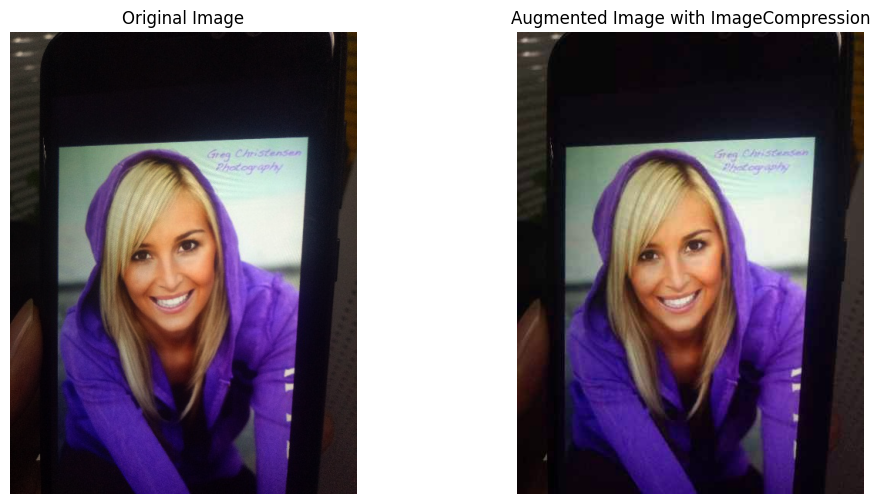

In [27]:
# ImageCompression
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# CoarseDropout
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.ImageCompression(
        quality_lower=10,
        quality_upper=50,
        p=1.0
    )
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="ImageCompression")

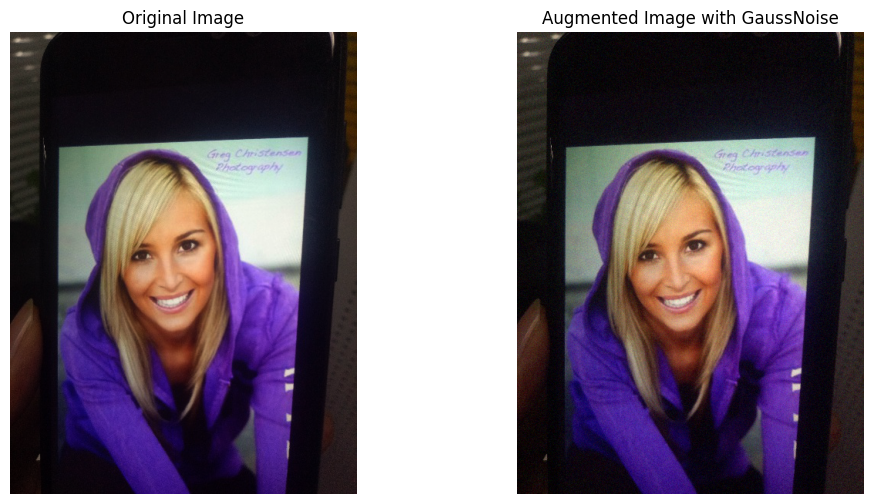

In [28]:
# GaussNoise
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# CoarseDropout
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.GaussNoise(
        p=1.0
    )
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="GaussNoise")

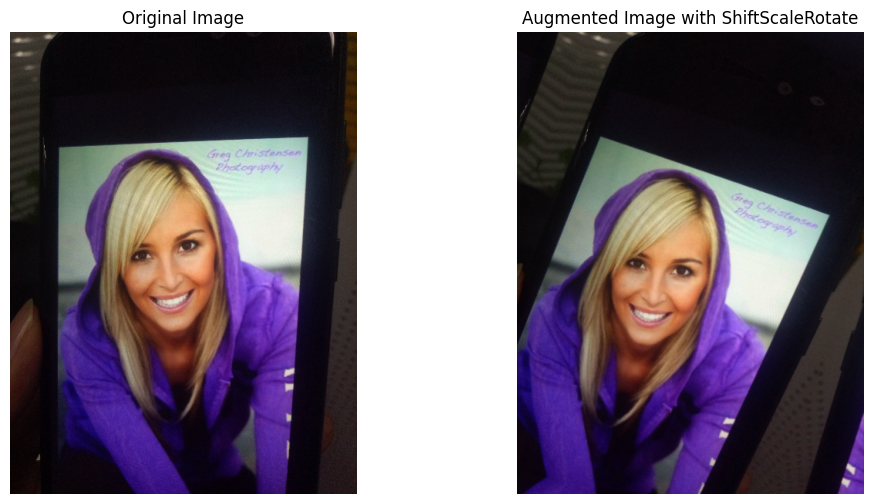

In [29]:
# ShiftScaleRotate
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# CoarseDropout
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.ShiftScaleRotate(
        p=1.0
    )
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="ShiftScaleRotate")

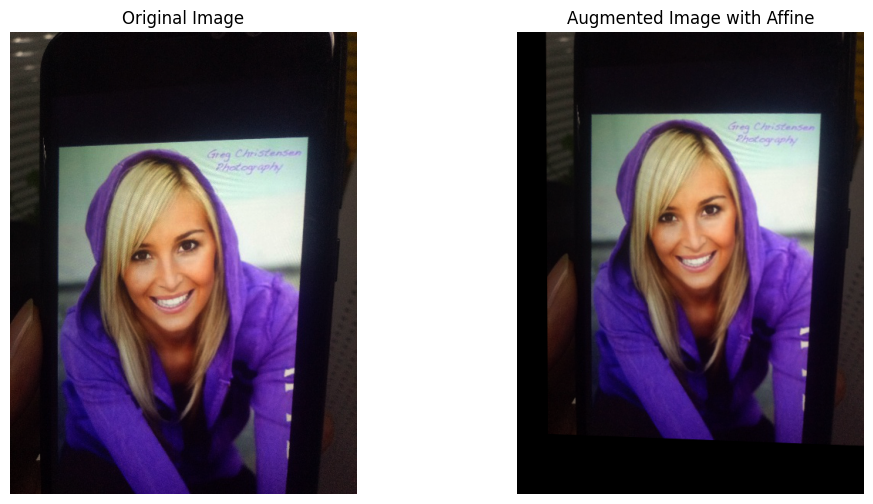

In [30]:
# Affine
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# CoarseDropout
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.Affine(
        p=1.0
    )
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="Affine")

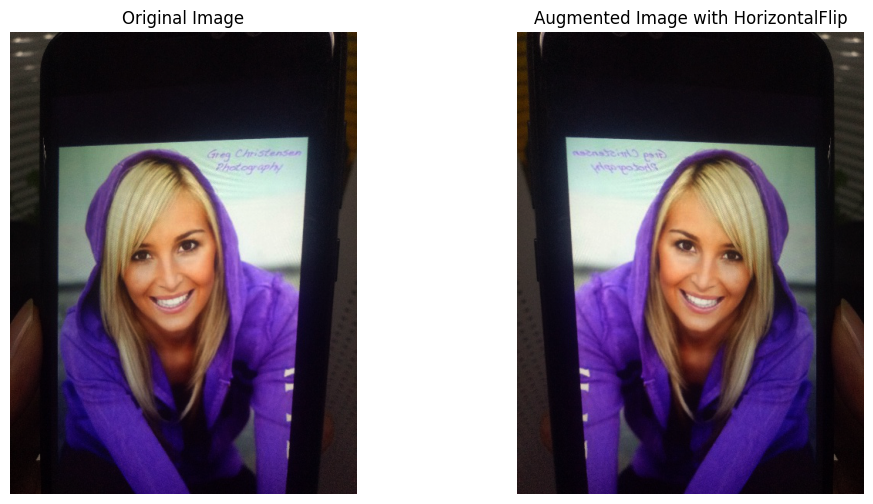

In [31]:
# HorizontalFlip
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# CoarseDropout
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.HorizontalFlip(
        p=1.0
    )
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="HorizontalFlip")

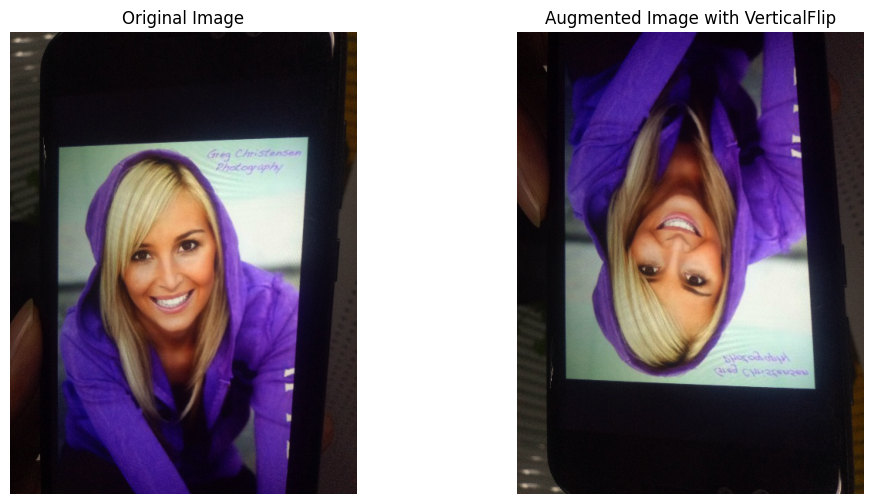

In [ ]:
# VerticalFlip
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# CoarseDropout
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.VerticalFlip(
        p=1.0
    )
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="VerticalFlip")

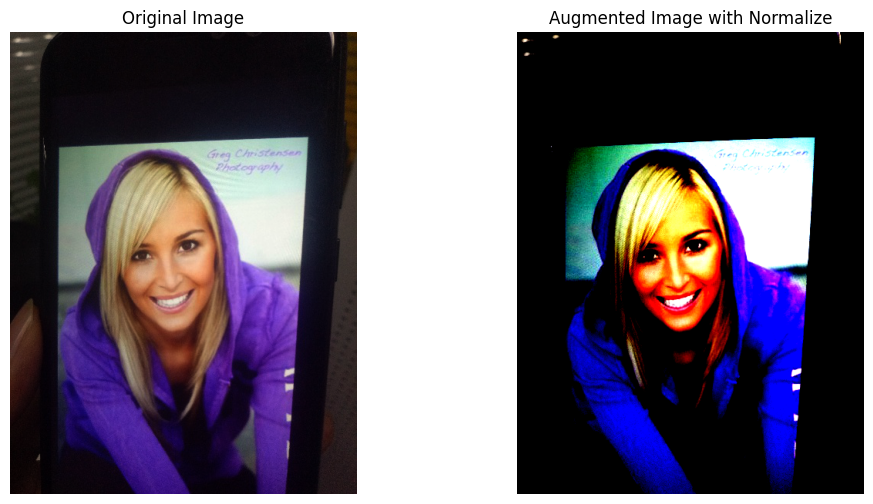

In [ ]:
# Normalize
example_image_path = "/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/9292/spoof/517180.png"

# CoarseDropout
img = cv2.imread(example_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = A.Compose([
    A.Normalize(
        p=1.0
    )
])
augmented_image = transform(image=img)["image"]
show_image(img, augmented_image, method="Normalize")

In [ ]:
img.shape

(600, 450, 3)

In [ ]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.augmentations.transforms.ISONoise(p=0.5),
    A.augmentations.transforms.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(blur_limit=3, p=0.5),
    A.augmentations.transforms.ImageCompression(p=0.5),
    A.augmentations.dropout.CoarseDropout(p=0.5),
    A.augmentations.transforms.GaussNoise(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.Affine(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

# Transformation for the input test/val images
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])

celea_transforms = {
    'train': train_transform,
    'val': test_transform,
}

In [ ]:
def extract_face(image_path: str, show: bool = False):
    img = Image.open(image_path)
    real_w, real_h = img.size
    
    bbox_path = "/".join(image_path.split("/")[:-1]) + "/" + image_path.split("/")[-1].split(".")[0] + "_BB.txt"
    
    bbox = open(bbox_path).readlines()[0]
    bbox = [int(n) for n in bbox.strip().split()[:4]]
    
    x1 = int(bbox[0] * (real_w / 224))
    y1 = int(bbox[1] * (real_h / 224))
    w1 = int(bbox[2] * (real_w / 224))
    h1 = int(bbox[3] * (real_h / 224))
    
    face = img.crop((x1, y1, x1 + w1, y1 + h1))
    if show:
        plt.imshow(face)
        plt.show()
    return np.array(face)

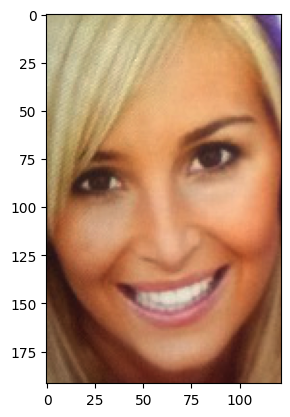

array([[[184, 179, 144],
        [180, 175, 140],
        [176, 171, 137],
        ...,
        [162, 157, 192],
        [207, 210, 226],
        [211, 221, 226]],

       [[184, 179, 144],
        [181, 176, 142],
        [176, 171, 137],
        ...,
        [148, 138, 184],
        [184, 183, 211],
        [211, 217, 228]],

       [[182, 177, 143],
        [185, 180, 145],
        [180, 175, 140],
        ...,
        [131, 115, 171],
        [164, 157, 198],
        [207, 209, 229]],

       ...,

       [[139, 114,  82],
        [139, 114,  82],
        [127, 101,  71],
        ...,
        [148, 102,  67],
        [152, 106,  70],
        [161, 114,  80]],

       [[136, 115,  82],
        [135, 110,  79],
        [134, 107,  77],
        ...,
        [148, 102,  67],
        [155, 108,  73],
        [160, 113,  79]],

       [[138, 116,  83],
        [135, 114,  81],
        [136, 112,  80],
        ...,
        [151, 105,  69],
        [160, 113,  77],
        [160, 113,  79]]

In [ ]:
extract_face(example_image_path, show=True)

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_path']
                
        cropped = extract_face(img_path)
        label = self.df.iloc[idx][43]
        label = torch.tensor(label).unsqueeze(0)
        
        if self.transforms is not None:
            image = self.transforms(image=cropped)['image']
            
        return image, label

In [ ]:
train_dataset = CelebADataset(df_train_sample_balanced, celea_transforms['train'])
val_dataset = CelebADataset(df_val_sample_balanced, celea_transforms['val'])

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
num_epochs = 60
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
scheduler = ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True, 
    threshold=0.005, min_lr=5e-7,
)

# dict to store history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'learning_rate': [],
}

best_val_loss = 0.0
save_dir = '/kaggle/working/'

# define checkpoint paths
cont_filepath = os.path.join(save_dir, "spoofnet_celeba-epoch_{}.pt")
best_filepath = os.path.join(save_dir, "spoofnet_celeba-best.pt")

def save_checkpoint(state, is_best, filename):
    torch.save(state, filename)
    if is_best:
        torch.save(state, best_filepath)

In [ ]:
for epoch in range(num_epochs):
    print('-----------------------')
    print('epoch: {}/{}'.format(epoch+1, num_epochs))
    print('-----------------------')
    
    model.train()
    
    running_loss = 0.0
    train_total = 0
    train_correct = 0
    prog_bar_train = tqdm(dataloader_train, desc="train")
    for inputs, labels in prog_bar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = (outputs > 0.5).int()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        prog_bar_train.set_postfix({"acc": round(train_correct / train_total, 2)})
    
    train_acc = 100 * train_correct / train_total
    avg_train_loss = running_loss / len(dataloader_train)
    
    history["train_loss"].append(avg_train_loss)
    history["train_accuracy"].append(train_acc)
    
    model.eval()
    running_val_loss = 0.0
    val_total = 0
    val_correct = 0
    prog_bar_val = tqdm(dataloader_val, desc="validate")
    with torch.no_grad():
        for inputs, labels in prog_bar_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            running_val_loss += loss.item()
            predicted = (outputs > 0.5).int()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    avg_val_loss = running_val_loss / len(dataloader_val)
    val_acc = 100 * val_correct / val_total
    
    
    history["val_loss"].append(avg_val_loss)
    history["val_accuracy"].append(val_acc)
    
    if epoch == 0:
        best_val_loss = avg_val_loss
        is_best = True
    else:
        is_best = avg_val_loss < best_val_loss
        best_val_loss = min(avg_val_loss, best_val_loss)
    
    checkpoint_filepath = cont_filepath.format(epoch+1)
    
    save_checkpoint(
        {
            "epoch": epoch + 1,
            "dataset": "CeleA FineTune",
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        },
        is_best,
        checkpoint_filepath
    )
    
    current_lr = optimizer.param_groups[0]["lr"]
    
    history["learning_rate"].append(current_lr)
    
    print(f"Epoch: {epoch + 1}/{num_epochs}")
    print(pd.DataFrame(history).tail())

-----------------------
epoch: 1/60
-----------------------


validate: 100%|██████████| 431/431 [12:38<00:00,  1.76s/it]


Epoch: 1/60
   train_loss   val_loss  train_accuracy  val_accuracy  learning_rate
0    0.196327  25.239712       92.000641      1.777294          0.001
-----------------------
epoch: 2/60
-----------------------


validate: 100%|██████████| 431/431 [11:21<00:00,  1.58s/it]


Epoch: 2/60
   train_loss   val_loss  train_accuracy  val_accuracy  learning_rate
0    0.196327  25.239712       92.000641      1.777294          0.001
1    0.113300  66.405244       95.856044      0.957563          0.001
-----------------------
epoch: 3/60
-----------------------


train:  62%|██████▏   | 243/390 [24:12<16:20,  6.67s/it, acc=0.96]